# 02.10.01 - SVM MFCC20 (70-30)

## Prerequisites

- The dataset exists (if not, execute 02.00.01)
- The dataset features have been populated (if not, execute 02.00.02)


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information
    predestination,                  # Seeds the various PRNGs for reproducibility 
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process


FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification

TRAINING_FRAC = 0.7       # size to select for training

KERNEL = 'rbf'            # svm kernel
C = 1                     # svm penalty factor
GAMMA = 'scale'           # rbf kernel gamma factor


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
ds.queryDataFrame(sql)

[2020-09-02/14:59:06.440|14.6%|89.2%|0.28GB] ------------------------------------------------------
[2020-09-02/14:59:06.440|00.0%|89.2%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-02/14:59:06.440|00.0%|89.2%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] SAMPLE RATE           : 22050
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] DURATION              : 1.0
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] OVERLAP               : 0.0
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-02/14:59:06.441|00.0%|89.2%|0.28GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


<hr style="border:1px solid gray"></hr>

### Step 2: Process SVM learning and display performance indicators

In [2]:
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainTest

# Seed the various PRNGs
predestination()

# Build training and test datasets
iprint(">>>>> Building partitions training/test")
X_train, X_test, y_train, y_test = splitTrainTest(
    df,
    TRAINING_FRAC,
    FEATURE_NAME,
    LABEL_NAME
)

# Standardize data 
iprint(">>>>> Standardize")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a SVM Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

#Train the model using the training sets
iprint('>>>>> Train')
clf.fit(X_train, y_train)

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-09-02/14:59:08.814|08.4%|91.1%|0.35GB] >>>>> Building partitions training/test
[2020-09-02/14:59:08.909|25.5%|91.8%|0.41GB] >>>>> Standardize
[2020-09-02/14:59:09.168|14.7%|92.0%|0.41GB] >>>>> Train
[2020-09-02/14:59:26.690|14.7%|90.9%|0.42GB] >>>>> Predict
[2020-09-02/14:59:33.528|13.3%|90.8%|0.42GB] Trained over 12043 / Tested over 5162
[2020-09-02/14:59:33.530|00.0%|90.8%|0.42GB] Accuracy  : 0.9957380860131732
[2020-09-02/14:59:33.533|00.0%|90.8%|0.42GB] Precision : 0.9968590498625834
[2020-09-02/14:59:33.536|00.0%|90.8%|0.42GB] Recall    : 0.9945162553858206
[2020-09-02/14:59:33.539|28.6%|90.8%|0.42GB] F-Measure : 0.9956862745098038


<hr style="border:1px solid gray"></hr>

### Step 3: Display performance report

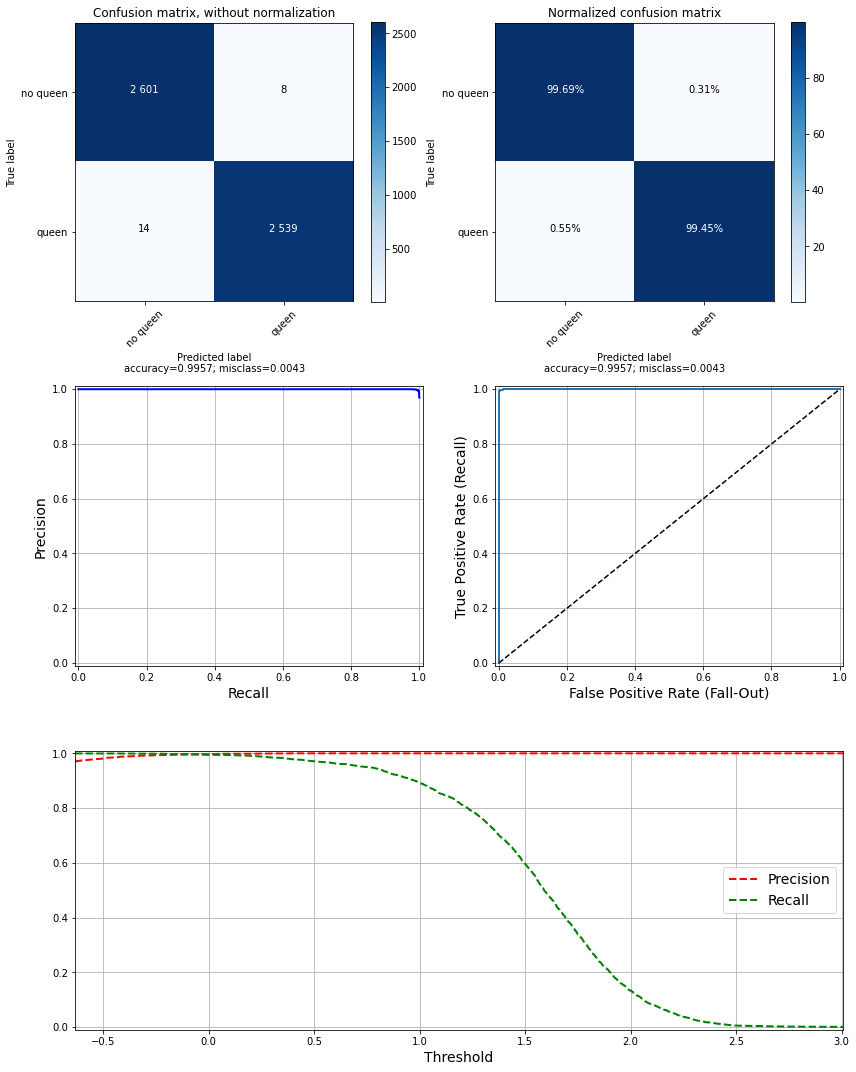

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.99      1.00      1.00      2609
       queen       1.00      0.99      1.00      2553

    accuracy                           1.00      5162
   macro avg       1.00      1.00      1.00      5162
weighted avg       1.00      1.00      1.00      5162

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.9999465527820554
------------------------------------------------------------------------------------------


In [3]:
from audace.plotters import clf_full_report

target_names = ['no queen', 'queen']
trn = int(TRAINING_FRAC*100)
figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - Trn{trn:02d} - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

# Display full report and save figures
clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")